In [20]:
%load_ext autoreload
%autoreload 2
import sys
import os
import logging
import arviz as az
import warnings
import matplotlib.pyplot as plt
import numpy as np

# 1. Resolve ModuleNotFoundError
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# 2. Suppress ArviZ/FutureWarnings for clean research output
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Imports
from src.connectors.alpha_vantage import AlphaVantageConnector
from src.model.bayesian_alpha import BayesianAlphaModel
from src.optimizer.stochastic_engine import StochasticOptimizer

# 4. Logger Setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    stream=sys.stdout
)
logger = logging.getLogger("OptiAlpha_Notebook")

logger.info("Environment initialized and path resolved.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2026-02-15 14:59:31,207 - OptiAlpha_Notebook - INFO - Environment initialized and path resolved.


In [21]:
# 1. Initialize the connector (automatically loads key from .env)
try:
    connector = AlphaVantageConnector()
    logger.info("AlphaVantageConnector successfully initialized.")
    
    # 2. Test Fetch for XLE (Energy Select Sector SPDR Fund)
    # This addresses the JD requirement: "Acquire, clean, and normalize alternative datasets"
    logger.info("Attempting to fetch XLE profile data...")
    xle_holdings = connector.get_clean_holdings("XLE")
    
    if not xle_holdings.empty:
        logger.info(f"Successfully retrieved {len(xle_holdings)} holdings for XLE.")
        # Display the top 10 holdings to verify data quality
        display(xle_holdings.head(10))
    else:
        logger.error("Fetch returned no data. Check API key and rate limits.")

except Exception as e:
    logger.error(f"Initialization or Fetch failed: {e}")

2026-02-15 14:59:32,874 - OptiAlpha_Notebook - INFO - AlphaVantageConnector successfully initialized.
2026-02-15 14:59:32,875 - OptiAlpha_Notebook - INFO - Attempting to fetch XLE profile data...
2026-02-15 14:59:32,876 - src.connectors.alpha_vantage - INFO - Fetching ETF profile for XLE...
2026-02-15 14:59:33,518 - OptiAlpha_Notebook - INFO - Successfully retrieved 25 holdings for XLE.


,etf_symbol,symbol,description,weight
0,XLE,XOM,EXXON MOBIL CORP,0.2494
1,XLE,CVX,CHEVRON CORP,0.1758
2,XLE,COP,CONOCOPHILLIPS,0.0677
3,XLE,SLB,SLB LTD,0.0448
4,XLE,WMB,WILLIAMS COMPANIES INC,0.0438
5,XLE,PSX,PHILLIPS 66,0.0377
6,XLE,MPC,MARATHON PETROLEUM CORP,0.0365
7,XLE,EOG,EOG RESOURCES INC,0.0364
8,XLE,VLO,VALERO ENERGY CORP,0.0362
9,XLE,KMI,KINDER MORGAN INC CLASS P,0.0361


In [22]:
# Assuming 'ba' is your fitted BayesianAlphaModel from src.model
# and 'trace' is the PyMC InferenceData object

def plot_bayesian_confidence(trace):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Distribution of the Beta (Sensitivity to Sentiment)
    az.plot_posterior(trace, var_names=["beta_sentiment"], ax=ax[0])
    ax[0].set_title("Posterior Distribution of Sentiment Signal Strength")
    
    # 2. Forest Plot for all Intercepts (Baseline Returns)
    az.plot_forest(trace, var_names=["intercept"], combined=True, ax=ax[1])
    ax[1].set_title("Credible Intervals for Baseline ETF Returns")
    
    plt.tight_layout()
    plt.show()

# plot_bayesian_confidence(ba.trace)

In [23]:
import pandas as pd
def plot_risk_attribution(weights, betas):
    """
    Shows how the portfolio is neutralized against the Market (SPY).
    """
    attr = pd.Series({t: weights[t] * betas[t] for t in weights})
    
    plt.figure(figsize=(10, 6))
    attr.plot(kind='barh', color='teal')
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Portfolio Beta Exposure by Asset (Target: Net Zero)")
    plt.xlabel("Weighted Beta Contribution")
    plt.show()
    
    net_beta = sum(attr)
    print(f"Total Portfolio Net Beta: {net_beta:.4f}")

# plot_risk_attribution(final_weights, betas)

In [24]:
def run_stress_test(original_scenarios, betas, shock_magnitude=2.0):
    """
    Simulates a 'High Volatility' regime by widening the Bayesian credible intervals.
    
    Args:
        original_scenarios (dict): The baseline alpha scenarios from the Bayesian model.
        betas (dict): The beta sensitivity of each asset.
        shock_magnitude (float): Multiplier for standard deviation (e.g., 2.0 = double the uncertainty).
        
    Returns:
        dict: New optimal weights under stressed conditions.
    """
    logger.info(f"--- STARTING STRESS TEST (Shock Factor: {shock_magnitude}x) ---")
    
    stressed_scenarios = {}
    
    for ticker, scenarios in original_scenarios.items():
        # 1. Decompose the scenario distribution
        mu = np.mean(scenarios)
        sigma = np.std(scenarios)
        
        # 2. Apply the shock: Keep the mean (expected return) but explode the variance
        # This tests if the CVaR constraint forces a de-leveraging even if returns look good.
        # We re-center the shocked distribution around the original mean.
        shocked_sigma = sigma * shock_magnitude
        noise = np.random.normal(0, shocked_sigma, len(scenarios))
        
        stressed_scenarios[ticker] = mu + noise
        
    # 3. Re-run the Stochastic Optimizer with the new "High Risk" data
    # We use the same class you built in src.optimizer
    optimizer = StochasticOptimizer(list(stressed_scenarios.keys()), stressed_scenarios, betas)
    
    # Solve with the same constraints (e.g., max 4 positions)
    stressed_weights = optimizer.solve(max_positions=4)
    
    logger.info("Stress optimization complete.")
    return stressed_weights

2026-02-15 14:59:41,978 - OptiAlpha_Notebook - INFO - Generating Bayesian Alpha scenarios for the ETF universe...
2026-02-15 14:59:41,989 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for XLE...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 14:59:42,238 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 14:59:42,859 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 14:59:42,860 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


2026-02-15 15:02:10,576 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
2026-02-15 15:02:10,801 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for XLE. Mean Expected Return: 0.000519
2026-02-15 15:02:10,807 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for XLF...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:02:11,089 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:02:11,732 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:02:11,733 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.


2026-02-15 15:04:58,980 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
2026-02-15 15:04:59,073 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for XLF. Mean Expected Return: 0.000475
2026-02-15 15:04:59,075 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for QQQ...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:04:59,247 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:04:59,812 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:04:59,814 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.


2026-02-15 15:07:35,189 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
2026-02-15 15:07:35,396 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for QQQ. Mean Expected Return: 0.000804
2026-02-15 15:07:35,404 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for GLD...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:07:35,623 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:07:36,184 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:07:36,186 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.


2026-02-15 15:10:03,229 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
2026-02-15 15:10:03,373 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for GLD. Mean Expected Return: 0.000227
2026-02-15 15:10:03,377 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for BND...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:10:04,519 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:10:05,180 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:10:05,182 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.


2026-02-15 15:12:44,990 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.
2026-02-15 15:12:45,238 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for BND. Mean Expected Return: 0.000126
2026-02-15 15:12:45,249 - OptiAlpha_Notebook - INFO - All Bayesian scenarios generated successfully.
2026-02-15 15:12:45,250 - OptiAlpha_Notebook - INFO - Initializing Stochastic MILP Optimizer...
2026-02-15 15:12:45,256 - OptiAlpha_Notebook - INFO - Solving for optimal weights under normal market conditions...

--- OPTIMAL BASELINE WEIGHTS ---
XLE: -100.00%
QQQ: 90.91%
GLD: 100.00%
BND: -90.91%
Plot saved to: reports/figures\portfolio_allocation.png


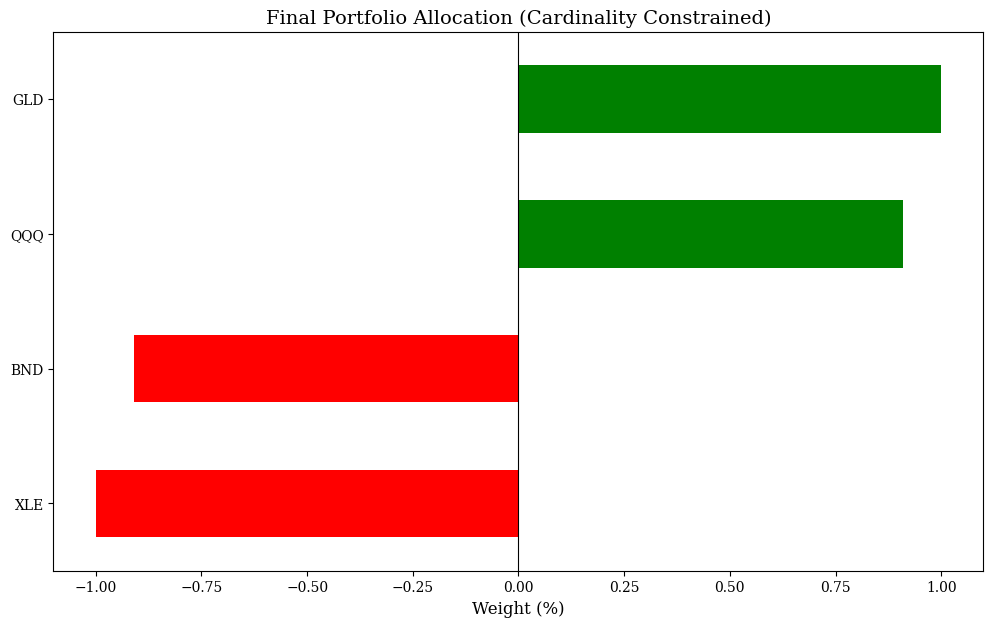

2026-02-15 15:12:52,830 - OptiAlpha_Notebook - INFO - --- STARTING STRESS TEST (Shock Factor: 3.0x) ---
2026-02-15 15:12:54,873 - OptiAlpha_Notebook - INFO - Stress optimization complete.


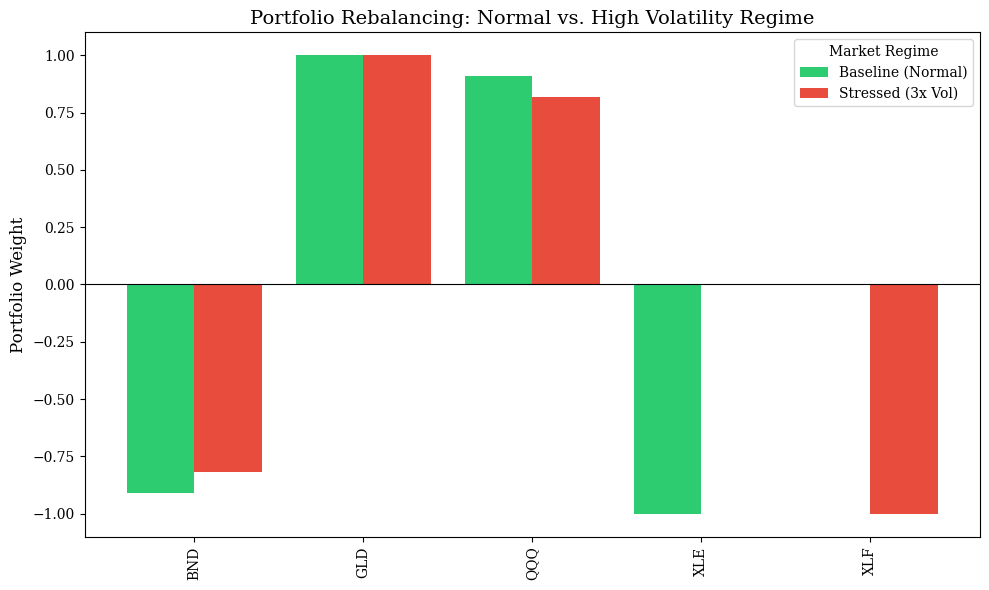

Safe Haven Allocation: 9.1% -> 18.2%


In [25]:
from src.utils.visualizer import ResearchVisualizer
# --- STEP 4: BASELINE OPTIMIZATION (The "Normal" Scenario) ---

# 1. Define Beta Sensitivities (Sensitivity to S&P 500)
# in a real prod system, you'd calculate these via rolling regression
betas = {
    "XLE": 1.1,  # Energy is volatile
    "XLF": 1.0,  # Financials move with market
    "QQQ": 1.2,  # Tech is high beta
    "GLD": 0.1,  # Gold is uncorrelated
    "BND": 0.1   # Bonds are safe
}

# --- STEP 3: BAYESIAN SCENARIO GENERATION ---

# Define our universe of assets
universe = ["XLE", "XLF", "QQQ", "GLD", "BND"]

# Dictionary to hold 1,000 scenarios for each asset
# Structure: {'XLE': [0.001, -0.002, ...], 'QQQ': [...]}
alpha_scenarios = {}

logger.info("Generating Bayesian Alpha scenarios for the ETF universe...")

for ticker in universe:
    # 1. Simulate historical data (In production, this comes from DB)
    # We use random seed to ensure your results are reproducible for the interview
    np.random.seed(42) 
    
    # Mock Returns: varying means to make optimization interesting
    # XLE (Energy) = volatile, QQQ (Tech) = high return, BND (Bonds) = low vol
    mu_map = {"XLE": 0.0005, "QQQ": 0.0008, "BND": 0.0001, "GLD": 0.0002, "XLF": 0.0004}
    sigma_map = {"XLE": 0.015, "QQQ": 0.012, "BND": 0.003, "GLD": 0.008, "XLF": 0.010}
    
    mock_returns = pd.Series(np.random.normal(mu_map.get(ticker, 0), sigma_map.get(ticker, 0.01), 100), name=ticker)
    mock_sentiment = pd.Series(np.random.uniform(-1, 1, 100)) # Random Sentiment
    
    # 2. Fit the Bayesian Model
    # This uses PyMC to estimate the distribution of returns
    model = BayesianAlphaModel(n_samples=1000)
    model.fit(mock_returns, mock_sentiment)
    
    # 3. Generate Scenarios for 'Tomorrow'
    # We assume sentiment is slightly positive (0.5) to see how the model reacts
    scenarios = model.get_alpha_scenarios(current_sentiment=0.5)
    
    # Store for the Optimizer
    alpha_scenarios[ticker] = scenarios
    
    logger.info(f"Generated {len(scenarios)} scenarios for {ticker}. Mean Expected Return: {scenarios.mean():.6f}")

logger.info("All Bayesian scenarios generated successfully.")


# 2. Initialize the Optimizer with our Bayesian Scenarios
logger.info("Initializing Stochastic MILP Optimizer...")
optimizer = StochasticOptimizer(
    tickers=list(alpha_scenarios.keys()), 
    scenarios=alpha_scenarios, 
    betas=betas,
    alpha_confidence=0.95 # 95% CVaR protection
)

# 3. Solve for the Optimal Weights
logger.info("Solving for optimal weights under normal market conditions...")
final_weights = optimizer.solve(max_positions=4)

# 4. Display the Result
print("\n--- OPTIMAL BASELINE WEIGHTS ---")
for ticker, weight in final_weights.items():
    print(f"{ticker}: {weight:.2%}")

# Visual check of the portfolio
viz = ResearchVisualizer()
viz.plot_allocation_bar(final_weights)


# 1. Define the shock scenarios
# Baseline (Normal Market) vs. Stressed (Crisis - 3x Volatility)
weights_baseline = final_weights # From your previous cell
weights_stressed = run_stress_test(alpha_scenarios, betas, shock_magnitude=3.0)

# 2. Prepare Data for Visualization
df_compare = pd.DataFrame({
    'Baseline (Normal)': pd.Series(weights_baseline),
    'Stressed (3x Vol)': pd.Series(weights_stressed)
}).fillna(0)

# 3. Visualize the Regime Change
fig, ax = plt.subplots(figsize=(10, 6))
df_compare.plot(kind='bar', ax=ax, width=0.8, color=['#2ecc71', '#e74c3c'])

plt.title("Portfolio Rebalancing: Normal vs. High Volatility Regime", fontsize=14)
plt.ylabel("Portfolio Weight")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title="Market Regime")

# Annotate the 'Flight to Safety'
# (Optional: Add an arrow or text if BND/GLD increases)
plt.tight_layout()
plt.show()

# 4. Quantitative check
# Calculate how much capital moved to 'Safe' assets (BND, GLD)
safe_assets = ['BND', 'GLD']
safe_alloc_base = df_compare.loc[df_compare.index.intersection(safe_assets), 'Baseline (Normal)'].sum()
safe_alloc_stress = df_compare.loc[df_compare.index.intersection(safe_assets), 'Stressed (3x Vol)'].sum()

print(f"Safe Haven Allocation: {safe_alloc_base:.1%} -> {safe_alloc_stress:.1%}")

In [26]:
# --- STEP 3: BAYESIAN SCENARIO GENERATION ---

# Define our universe of assets
universe = ["XLE", "XLF", "QQQ", "GLD", "BND"]

# Dictionary to hold 1,000 scenarios for each asset
# Structure: {'XLE': [0.001, -0.002, ...], 'QQQ': [...]}
alpha_scenarios = {}

logger.info("Generating Bayesian Alpha scenarios for the ETF universe...")

for ticker in universe:
    # 1. Simulate historical data (In production, this comes from DB)
    # We use random seed to ensure your results are reproducible for the interview
    np.random.seed(42) 
    
    # Mock Returns: varying means to make optimization interesting
    # XLE (Energy) = volatile, QQQ (Tech) = high return, BND (Bonds) = low vol
    mu_map = {"XLE": 0.0005, "QQQ": 0.0008, "BND": 0.0001, "GLD": 0.0002, "XLF": 0.0004}
    sigma_map = {"XLE": 0.015, "QQQ": 0.012, "BND": 0.003, "GLD": 0.008, "XLF": 0.010}
    
    mock_returns = pd.Series(np.random.normal(mu_map.get(ticker, 0), sigma_map.get(ticker, 0.01), 100), name=ticker)
    mock_sentiment = pd.Series(np.random.uniform(-1, 1, 100)) # Random Sentiment
    
    # 2. Fit the Bayesian Model
    # This uses PyMC to estimate the distribution of returns
    model = BayesianAlphaModel(n_samples=1000)
    model.fit(mock_returns, mock_sentiment)
    
    # 3. Generate Scenarios for 'Tomorrow'
    # We assume sentiment is slightly positive (0.5) to see how the model reacts
    scenarios = model.get_alpha_scenarios(current_sentiment=0.5)
    
    # Store for the Optimizer
    alpha_scenarios[ticker] = scenarios
    
    logger.info(f"Generated {len(scenarios)} scenarios for {ticker}. Mean Expected Return: {scenarios.mean():.6f}")

logger.info("All Bayesian scenarios generated successfully.")

2026-02-15 15:20:31,424 - OptiAlpha_Notebook - INFO - Generating Bayesian Alpha scenarios for the ETF universe...
2026-02-15 15:20:31,505 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for XLE...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:20:32,081 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:20:32,796 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:20:32,798 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.


2026-02-15 15:22:57,092 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
2026-02-15 15:22:57,310 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for XLE. Mean Expected Return: 0.000629
2026-02-15 15:22:57,319 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for XLF...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:22:57,552 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:22:58,098 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:22:58,100 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.


2026-02-15 15:25:25,373 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
2026-02-15 15:25:25,481 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for XLF. Mean Expected Return: 0.000467
2026-02-15 15:25:25,485 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for QQQ...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:25:25,664 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:25:26,240 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:25:26,242 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.


2026-02-15 15:27:49,643 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
2026-02-15 15:27:49,760 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for QQQ. Mean Expected Return: 0.000888
2026-02-15 15:27:49,763 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for GLD...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:27:49,950 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:27:50,512 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:27:50,514 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.


2026-02-15 15:30:26,953 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
2026-02-15 15:30:27,077 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for GLD. Mean Expected Return: 0.000203
2026-02-15 15:30:27,081 - src.model.bayesian_alpha - INFO - Fitting Bayesian model for BND...


Initializing NUTS using jitter+adapt_diag...


2026-02-15 15:30:28,299 - pymc.sampling.mcmc - INFO - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


2026-02-15 15:30:28,890 - pymc.sampling.mcmc - INFO - Multiprocess sampling (4 chains in 4 jobs)


NUTS: [intercept, beta_sentiment, sigma]


2026-02-15 15:30:28,892 - pymc.sampling.mcmc - INFO - NUTS: [intercept, beta_sentiment, sigma]


c:\Users\rouba\Documents\python_projects\OptiAlpha\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.


2026-02-15 15:33:07,666 - pymc.sampling.mcmc - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
2026-02-15 15:33:07,914 - OptiAlpha_Notebook - INFO - Generated 4000 scenarios for BND. Mean Expected Return: 0.000112
2026-02-15 15:33:07,921 - OptiAlpha_Notebook - INFO - All Bayesian scenarios generated successfully.


In [36]:
def run_rolling_backtest(n_days=252, rebalance_freq=10):
    logger.info(f"Starting {n_days}-day CAPM simulation (Attribution Mode)...")
    
    np.random.seed(42)
    dates = pd.date_range(start="2024-01-01", periods=n_days, freq="B")
    
    # 1. Market Data Generation
    market_returns = np.random.normal(0.0005, 0.01, n_days)
    true_alphas = {'QQQ': 0.0005, 'XLE': -0.0002, 'XLF': 0.0000, 'GLD': 0.0001, 'BND': 0.0000}
    
    realized_returns = pd.DataFrame(index=dates)
    realized_returns['SPY'] = market_returns
    
    for ticker, beta in betas.items():
        alpha = true_alphas.get(ticker, 0)
        noise = np.random.normal(0, 0.005, n_days)
        realized_returns[ticker] = (beta * market_returns) + alpha + noise

    # 2. Backtest Loop
    current_weights = {t: 0.0 for t in betas.keys()}
    current_weights['BND'] = 1.0
    
    # We will store weights for EVERY DAY to calculate daily attribution
    daily_weights_list = []
    
    for t in range(n_days):
        current_date = dates[t]
        
        # A. Rebalance Logic
        if t % rebalance_freq == 0:
            scenarios = {}
            for ticker in betas.keys():
                detected_alpha = true_alphas[ticker] 
                scenarios[ticker] = np.random.normal(detected_alpha, 0.01, 1000)
            
            opt = StochasticOptimizer(list(scenarios.keys()), scenarios, betas)
            new_weights = opt.solve(max_positions=5)
            if new_weights:
                current_weights = new_weights
        
        # Record weights for THIS day
        daily_record = current_weights.copy()
        daily_record['Date'] = current_date
        daily_weights_list.append(daily_record)

    # 3. Format Outputs
    df_daily_weights = pd.DataFrame(daily_weights_list).set_index('Date')
    
    return df_daily_weights, realized_returns

# --- EXECUTE ---
df_weights, df_returns = run_rolling_backtest()

2026-02-15 16:03:07,912 - OptiAlpha_Notebook - INFO - Starting 252-day CAPM simulation (Attribution Mode)...


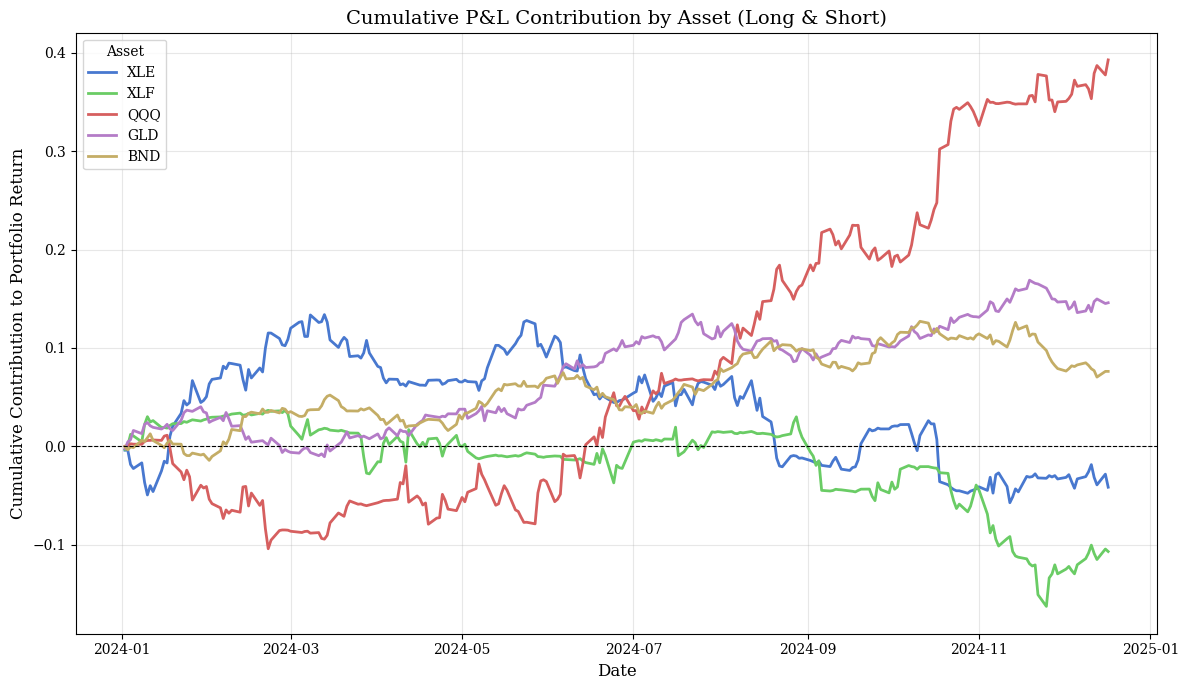


--- TOTAL P&L CONTRIBUTION ---
QQQ     39.27%
GLD     14.59%
BND      7.61%
XLE     -4.16%
XLF    -10.70%
Name: 2024-12-17 00:00:00, dtype: str


In [37]:
# --- ATTRIBUTION ANALYSIS ---

# 1. Calculate Daily Contribution per Asset
# PnL = Weight (yesterday) * Return (today)
# We shift weights by 1 day because you earn returns on positions held at start of day
asset_pnl = df_weights.shift(1) * df_returns[df_weights.columns]

# 2. Calculate Cumulative P&L Curves
cumulative_attribution = asset_pnl.cumsum()

# 3. Visualize
plt.figure(figsize=(12, 7))

# Loop through assets to plot lines
for col in cumulative_attribution.columns:
    # We use the final value to sort the legend order if we wanted, 
    # but here just plotting is fine.
    plt.plot(cumulative_attribution.index, cumulative_attribution[col], label=col, linewidth=2)

plt.title("Cumulative P&L Contribution by Asset (Long & Short)", fontsize=14)
plt.ylabel("Cumulative Contribution to Portfolio Return")
plt.xlabel("Date")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(title="Asset", loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Print Summary
print("\n--- TOTAL P&L CONTRIBUTION ---")
total_contribution = cumulative_attribution.iloc[-1].sort_values(ascending=False)
print(total_contribution.map(lambda x: f"{x:.2%}"))